In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_narrow_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [20]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=1, sigma=1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=1, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.3)
    beta_H = pm.Normal("beta_H", mu=3, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=10, sigma=3)
    alpha_1 = pm.Normal("alpha_1", mu=10, sigma=3)
    alpha_2 = pm.Normal("alpha_2", mu=10, sigma=3)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [21]:
error_mean

0.06657632155446756

In [22]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 303 seconds.
There were 2189 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB -0.574 -1.717 -1.826 ... -2.355 -2.127
     alpha_2  (chain, draw) float64 192kB -2.878 -2.918 -2.889 ... -2.895 -2.878
     alpha_L  (chain, draw) float64 192kB 12.59 11.82 14.0 ... 12.11 13.86 13.7
     beta_H   (chain, draw) float64 192kB 0.8131 0.8403 0.8518 ... 0.8655 0.8591
     beta_H2  (chain, draw) float64 192kB 0.09894 0.08875 ... 0.0936 0.09456
     beta_L   (chain, draw) float64 192kB 1.065 1.085 1.079 ... 1.056 1.088 1.086
     eta      (chain, draw) float64 192kB 0.03033 0.0308 ... 0.03121 0.0308
     rho      (chain, draw) float64 192kB 123.8 140.8 145.7 ... 150.5 152.9 152.0
     sigma    (chain, draw) float64 192kB 0.0727 0.0726 ... 0.07267 0.07305
 Attributes:
     created_at:                 2024-08-2

In [24]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 192kB -0.574 -1.717 -1.826 ... -2.355 -2.127
    alpha_2  (chain, draw) float64 192kB -2.878 -2.918 -2.889 ... -2.895 -2.878
    alpha_L  (chain, draw) float64 192kB 12.59 11.82 14.0 ... 12.11 13.86 13.7
    beta_H   (chain, draw) float64 192kB 0.8131 0.8403 0.8518 ... 0.8655 0.8591
    beta_H2  (chain, draw) float64 192kB 0.09894 0.08875 ... 0.0936 0.09456
    beta_L   (chain, draw) float64 192kB 1.065 1.085 1.079 ... 1.056 1.088 1.086
    eta      (chain, draw) float64 192kB 0.03033 0.0308 ... 0.03121 0.0308
    rho      (chain, draw) float64 192kB 123.8 140.8 145.7 ... 150.5 152.9 152.0
    sigma    (chain, draw) float64 192kB 0.0727 0.0726 ... 0.07267 0.07305

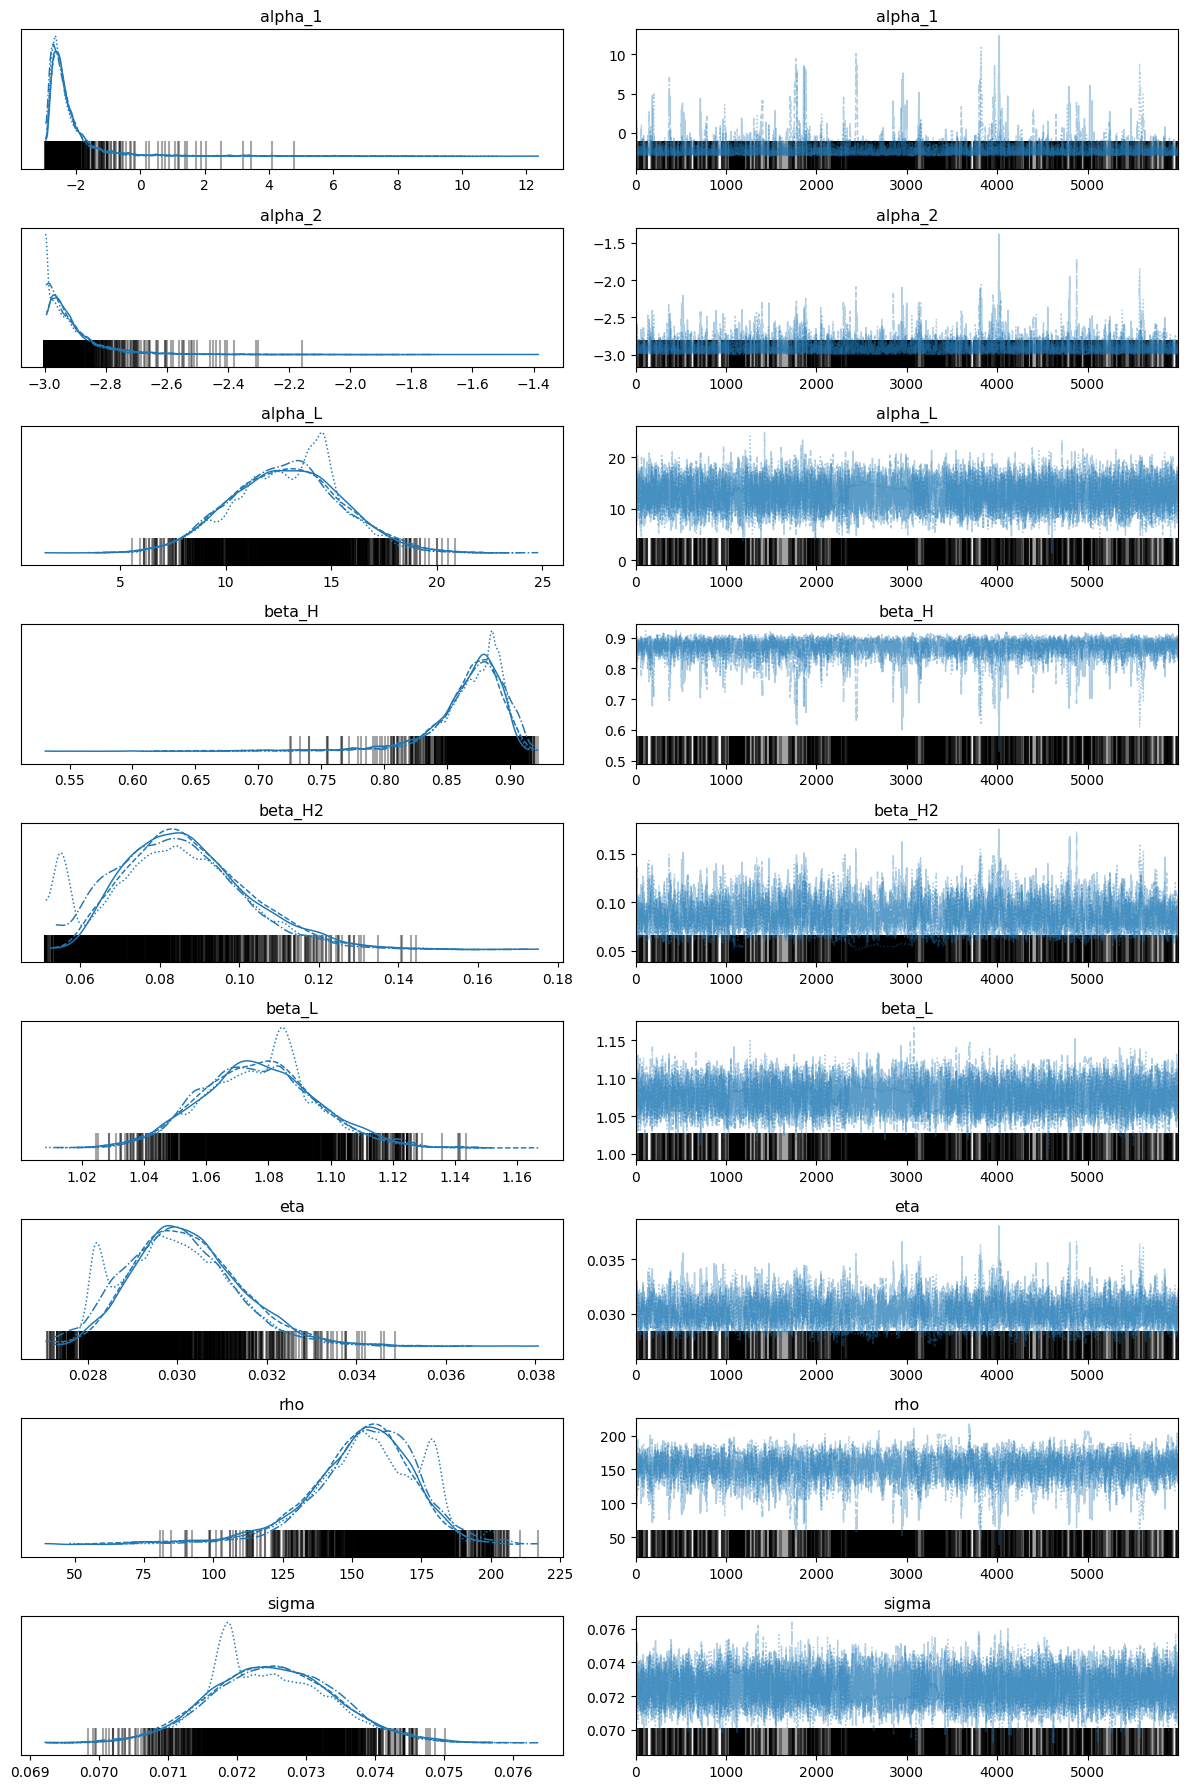

In [25]:
az.plot_trace(idata)
plt.tight_layout()

In [26]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.02889105 0.03003393 0.03129439]
[136.26328701 155.53157118 172.57822225]
[1.05821508 1.07671005 1.09457868]
[0.84578668 0.87378962 0.8920286 ]


In [27]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,-2.172,1.106,-2.945,-0.914,0.035,0.025,1098.511,1444.291,1.006
alpha_2,-2.905,0.101,-2.998,-2.739,0.003,0.002,214.317,46.568,1.017
alpha_L,12.875,2.602,7.940,17.654,0.041,0.029,4041.564,6734.421,1.001
beta_H,0.867,0.032,0.816,0.912,0.001,0.001,1046.785,1203.020,1.007
beta_H2,0.085,0.016,0.054,0.113,0.001,0.001,225.966,39.608,1.016
beta_L,1.077,0.018,1.043,1.113,0.000,0.000,3129.593,2145.139,1.001
eta,0.030,0.001,0.028,0.032,0.000,0.000,402.038,152.056,1.012
rho,153.751,20.218,115.335,188.506,0.781,0.598,537.403,1216.038,1.009
sigma,0.073,0.001,0.071,0.074,0.000,0.000,3693.326,5568.466,1.002


In [28]:
posterior_eta.values.flatten()

array([0.03032917, 0.03079965, 0.03046731, ..., 0.02921017, 0.03121198,
       0.03080032])

In [29]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: -2.6394085643657217
alpha_2: -2.995954521552407
alpha_L: 14.228183427640552
beta_H: 0.885607930531086
beta_H2: 0.08041007271308513
beta_L: 1.0844837421219857
eta: 0.02981267945191996
rho: 154.66617045902836
sigma: 0.07190139782678141


In [30]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: -2.6083526710433507
alpha_2: -2.970099456820443
alpha_L: 13.936565967442835
beta_H: 0.8820336835377713
beta_H2: 0.08379057616699197
beta_L: 1.0834460833214496
eta: 0.029782332086035476
rho: 155.67211332086444
sigma: 0.07252021997066616


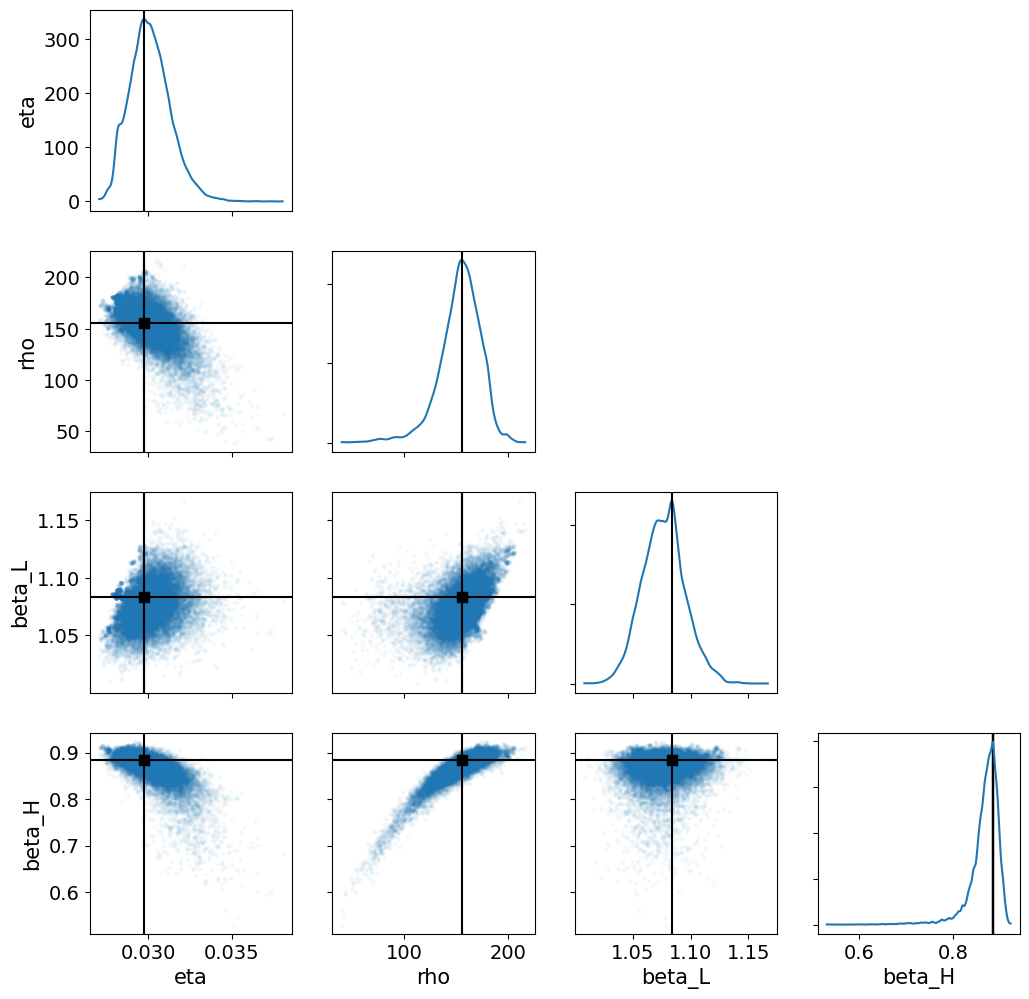

In [31]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [32]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H', 'beta_H2', 'alpha_L', 'alpha_1', 'alpha_2', 'sigma']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma): [ 1.53747855e+02  2.99367092e-02  1.07328528e+00  8.71883146e-01
  8.47645678e-02  1.28876464e+01 -2.38777198e+00 -2.92978452e+00
  7.25824839e-02]


In [33]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [34]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [35]:
loss

1.7733144792180255